In [1]:
from PIL import Image
import cv2
import torch
import math 
import utils_rotate
from IPython.display import display
import os

In [2]:
# load yolo model for detect and character detection stage
# please download yolov5 from our link on github
yolo_LP_detect = torch.hub.load('yolov5', 'custom', path='model/LP_detector.pt', force_reload=True, source='local')
yolo_license_plate = torch.hub.load('yolov5', 'custom', path='model/LP_ocr.pt', force_reload=True, source='local')

# set model confidence threshold 
# yolo_LP_detect.conf = 0.6
yolo_license_plate.conf = 0.60

YOLOv5  v6.1-179-gf3fecf9 torch 1.11.0+cpu CPU

Fusing layers... 
Model summary: 290 layers, 20852934 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  v6.1-179-gf3fecf9 torch 1.11.0+cpu CPU

Fusing layers... 
Model summary: 290 layers, 20970123 parameters, 0 gradients
Adding AutoShape... 


In [3]:
# license plate type classification helper function
def linear_equation(x1, y1, x2, y2):
    b = y1 - (y2 - y1) * x1 / (x2 - x1)
    a = (y1 - b) / x1
    return a, b

def check_point_linear(x, y, x1, y1, x2, y2):
    a, b = linear_equation(x1, y1, x2, y2)
    y_pred = a*x+b
    return(math.isclose(y_pred, y, abs_tol = 3))

In [9]:
def read_plate():
    LP_type = "1"
    im = Image.open("cache.jpg")
    results = yolo_license_plate(im)
    bb_list = results.pandas().xyxy[0].values.tolist()
    if len(bb_list) == 0 or len(bb_list) < 7 or len(bb_list) > 10:
        return "unknown"
    center_list = []
    y_mean = 0
    y_sum = 0
    for bb in bb_list:
        x_c = (bb[0]+bb[2])/2
        y_c = (bb[1]+bb[3])/2
        y_sum += y_c
        center_list.append([x_c,y_c,bb[-1]])

    # find 2 point to draw line
    l_point = center_list[0]
    r_point = center_list[0]
    for cp in center_list:
        if cp[0] < l_point[0]:
            l_point = cp
        if cp[0] > r_point[0]:
            r_point = cp
    for ct in center_list:
        if l_point[0] != r_point[0]:
            if (check_point_linear(ct[0], ct[1], l_point[0], l_point[1], r_point[0], r_point[1]) == False):
                LP_type = "2"

    y_mean = int(int(y_sum) / len(bb_list))
    size = results.pandas().s

    # 1 line plates and 2 line plates
    line_1 = []
    line_2 = []
    license_plate = ""
    if LP_type == "2":
        for c in center_list:
            if int(c[1]) > y_mean:
                line_2.append(c)
            else:
                line_1.append(c)
        for l1 in sorted(line_1, key = lambda x: x[0]):
            license_plate += str(l1[2])
        license_plate += "-"
        for l2 in sorted(line_2, key = lambda x: x[0]):
            license_plate += str(l2[2])
    else:
        for l in sorted(center_list, key = lambda x: x[0]):
            license_plate += str(l[2])
    return license_plate

In [24]:
#enter image path here
img_file = "test_image/557.png"
img = Image.open(img_file)
plates = yolo_LP_detect(img, size=640)

In [25]:
list_plates = plates.pandas().xyxy[0].values.tolist()
list_read_plates = set()
if len(list_plates) == 0:
    img_c = cv2.imread(img_file)
    cv2.imwrite("cache.jpg", img_c)
    lp = read_plate()
    if lp != "unknown":
        list_read_plates.add(lp)
else:
    img_c = cv2.imread(img_file)
    for plate in list_plates:
        flag = 0
        x = int(plate[0]) # xmin
        y = int(plate[1]) # ymin
        w = int(plate[2] - plate[0]) # xmax - xmin
        h = int(plate[3] - plate[1]) # ymax - ymin  
        crop_img = img_c[y:y+h, x:x+w]
        cv2.imwrite("crop.jpg", crop_img)
        rc_image = cv2.imread("crop.jpg")
        lp = ""
        for cc in range(0,2):
            for ct in range(0,2):
                cv2.imwrite("cache.jpg", utils_rotate.deskew(rc_image, cc, ct))
                lp = read_plate()
                if lp != "unknown":
                    list_read_plates.add(lp)
                    flag = 1
                    break
            if flag == 1:
                break

{'75H1-42599', '75F1-586', '75A-18283', '75H1-36121'}


C:\Users\Admin\AppData\Local\Temp\ipykernel_17620\3102910202.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)


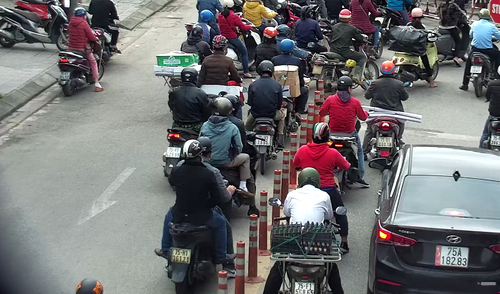

In [26]:
print(list_read_plates)
basewidth = 500
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
display(img)